In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import lightgbm

from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

%matplotlib inline

In [35]:
rep_cols = {'ID':'ID', 
 '板温':'board_t', 
 '现场温度':'env_t', 
 '光照强度':'light_strength', 
 '转换效率':'efficiency', 
 '转换效率A':'efficiency_A', 
 '转换效率B':'efficiency_B', 
 '转换效率C':'efficiency_C', 
 '电压A':'V_A',
 '电压B':'V_B', 
 '电压C':'V_C', 
 '电流A':'I_A', 
 '电流B':'I_B', 
 '电流C':'I_C', 
 '功率A':'P_A', 
 '功率B':'P_B', 
 '功率C':'P_C', 
 '平均功率':'P_avg', 
 '风速':'wind_speed',
 '风向':'wind_direction', 
 '发电量':'y'
}

In [36]:
def my_val(preds, train_data):
    label = train_data.get_label()
    return 'score', 1/(1+np.sqrt(mean_squared_error(preds, label))), True

In [37]:
def my_obj(preds, train_data):
    labels = train_data.get_label()
    

In [38]:
train = pd.read_csv('../data/public.train.csv')
test = pd.read_csv('../data/public.test.csv')

train_len = train.shape[0]

df = pd.concat([train, test])

C:\Users\Alex\Anaconda3\envs\python36\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


In [39]:
df.rename(index=str, columns=rep_cols, inplace=True)

In [40]:
df.head()

,ID,light_strength,P_A,P_B,P_C,y,P_avg,board_t,env_t,V_A,...,V_C,I_A,I_B,I_C,efficiency,efficiency_A,efficiency_B,efficiency_C,wind_direction,wind_speed
0,10,34,976.86,155.98,1087.50,1.437752,740.11,-19.14,-17.4,729,...,725,1.34,0.22,1.50,80.55,106.32,16.98,118.36,272,0.6
1,11,30,1128.40,172.08,1132.56,1.692575,811.01,-18.73,-17.3,728,...,726,1.55,0.24,1.56,99.90,139.00,21.20,139.51,275,0.8
2,12,41,1279.25,166.06,1310.40,1.975787,918.57,-17.54,-17.0,731,...,720,1.75,0.23,1.82,82.48,114.86,14.91,117.66,283,1.1
3,14,53,1474.60,225.37,1517.34,2.370656,1072.44,-15.43,-16.6,730,...,726,2.02,0.31,2.09,73.98,101.72,15.55,104.67,280,0.9
4,15,65,1548.51,233.28,1674.40,2.532091,1152.06,-14.60,-16.3,727,...,728,2.13,0.32,2.30,64.62,86.86,13.09,93.92,280,1.1


In [41]:
print(df.columns)

Index(['ID', 'light_strength', 'P_A', 'P_B', 'P_C', 'y', 'P_avg', 'board_t',
       'env_t', 'V_A', 'V_B', 'V_C', 'I_A', 'I_B', 'I_C', 'efficiency',
       'efficiency_A', 'efficiency_B', 'efficiency_C', 'wind_direction',
       'wind_speed'],
      dtype='object')


In [42]:
#异常值处理
cols = [c for c in df.columns.tolist() if c!='y' and c!='ID']
for c in cols:
    df[c] = np.clip(df[c],df[c].quantile(0.01),df[c].quantile(0.99))

In [43]:
train = df.iloc[0:train_len]
test = df.iloc[train_len:]

In [44]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression_l2',
    'metric': 'mse',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}

In [45]:
predictor = [c for c in train.columns.tolist() if c!='y' and c!='ID']

In [46]:
kf = KFold(5, shuffle=True, random_state=2018)

In [47]:
test_predicts = []
val_preds = np.zeros(train.shape[0])
for n_fold, (tra_idx, val_idx) in enumerate(kf.split(train)):
    tra = train.iloc[tra_idx]
    val = train.iloc[val_idx]
    
    train_set = lightgbm.Dataset(
        tra[predictor],
        tra['y']
    )
    
    validation_set = lightgbm.Dataset(
        val[predictor],
        val['y']
    )
    
    model = lightgbm.train(params, train_set, num_boost_round=5000,
                          valid_sets= [validation_set],
                          valid_names=['valid'],
                          early_stopping_rounds=100,
                           feval=my_val,
                          verbose_eval=100)

    val_preds[val_idx] = model.predict(val[predictor])
    test_predicts.append(model.predict(test[predictor]))

Training until validation scores don't improve for 100 rounds.
[100]	valid's l2: 0.115498	valid's score: 0.746352
[200]	valid's l2: 0.104046	valid's score: 0.756109
[300]	valid's l2: 0.097634	valid's score: 0.761925
[400]	valid's l2: 0.0935326	valid's score: 0.765796
[500]	valid's l2: 0.0909492	valid's score: 0.768298
[600]	valid's l2: 0.0891919	valid's score: 0.77003
[700]	valid's l2: 0.0877329	valid's score: 0.771487
[800]	valid's l2: 0.0866759	valid's score: 0.772554
[900]	valid's l2: 0.0858255	valid's score: 0.773419
[1000]	valid's l2: 0.0852618	valid's score: 0.773996
[1100]	valid's l2: 0.0848895	valid's score: 0.774379
[1200]	valid's l2: 0.084592	valid's score: 0.774685
[1300]	valid's l2: 0.0843164	valid's score: 0.77497
[1400]	valid's l2: 0.08409	valid's score: 0.775204
[1500]	valid's l2: 0.0839243	valid's score: 0.775376
[1600]	valid's l2: 0.0837224	valid's score: 0.775586
[1700]	valid's l2: 0.0835902	valid's score: 0.775723
[1800]	valid's l2: 0.0834875	valid's score: 0.77583
[

In [48]:
test['ans'] = np.mean(test_predicts, axis=0)

C:\Users\Alex\Anaconda3\envs\python36\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [49]:
test[['ID','ans']].to_csv('../result/baseline073100.csv',header=False, index=False)

In [ ]:
#20180731 Trial 1: 去除训练集中异常数据（p异常），将测试集中异常数据按照线性模型拉回真实值附近

In [66]:
train_raw = pd.read_csv('../data/public.train.csv')
test_raw = pd.read_csv('../data/public.test.csv')

train_raw_len = train_raw.shape[0]

#为了统一处理表头编码问题，合并
train_test_raw = pd.concat([train_raw, test_raw],sort=False)

train_test_raw.rename(index=str, columns=rep_cols, inplace=True)

train_test_raw.head()

,ID,board_t,env_t,light_strength,efficiency,efficiency_A,efficiency_B,efficiency_C,V_A,V_B,...,I_A,I_B,I_C,P_A,P_B,P_C,P_avg,wind_speed,wind_direction,y
0,10,-19.14,-17.4,34,80.55,106.32,16.98,118.36,729,709,...,1.34,0.22,1.50,976.86,155.98,1087.50,740.11,0.6,272,1.437752
1,11,-18.73,-17.3,30,99.90,139.00,21.20,139.51,728,717,...,1.55,0.24,1.56,1128.40,172.08,1132.56,811.01,0.8,275,1.692575
2,12,-17.54,-17.0,41,82.48,114.86,14.91,117.66,731,722,...,1.75,0.23,1.82,1279.25,166.06,1310.40,918.57,1.1,283,1.975787
3,14,-15.43,-16.6,53,73.98,101.72,15.55,104.67,730,727,...,2.02,0.31,2.09,1474.60,225.37,1517.34,1072.44,0.9,280,2.370656
4,15,-14.60,-16.3,65,64.62,86.86,13.09,93.92,727,729,...,2.13,0.32,2.30,1548.51,233.28,1674.40,1152.06,1.1,280,2.532091


In [61]:
print("train set size: "+str(train_raw.shape[0])+", test set size: "+str(test_raw.shape[0]))

train set size: 9000, test set size: 8409


In [67]:
train_test_raw.shape[0]

17409

In [73]:
#覆盖**_raw，数据内容未变，表头已转为英文
train_raw = train_test_raw.iloc[0:train_raw_len]
test_raw = train_test_raw.iloc[train_raw_len:]

In [74]:
train_raw.head()

,ID,board_t,env_t,light_strength,efficiency,efficiency_A,efficiency_B,efficiency_C,V_A,V_B,...,I_A,I_B,I_C,P_A,P_B,P_C,P_avg,wind_speed,wind_direction,y
0,10,-19.14,-17.4,34,80.55,106.32,16.98,118.36,729,709,...,1.34,0.22,1.50,976.86,155.98,1087.50,740.11,0.6,272,1.437752
1,11,-18.73,-17.3,30,99.90,139.00,21.20,139.51,728,717,...,1.55,0.24,1.56,1128.40,172.08,1132.56,811.01,0.8,275,1.692575
2,12,-17.54,-17.0,41,82.48,114.86,14.91,117.66,731,722,...,1.75,0.23,1.82,1279.25,166.06,1310.40,918.57,1.1,283,1.975787
3,14,-15.43,-16.6,53,73.98,101.72,15.55,104.67,730,727,...,2.02,0.31,2.09,1474.60,225.37,1517.34,1072.44,0.9,280,2.370656
4,15,-14.60,-16.3,65,64.62,86.86,13.09,93.92,727,729,...,2.13,0.32,2.30,1548.51,233.28,1674.40,1152.06,1.1,280,2.532091


(array([8.977e+03, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 2.200e+01]),
 array([     0.   ,  16015.137,  32030.274,  48045.411,  64060.548,
         80075.685,  96090.822, 112105.959, 128121.096, 144136.233,
        160151.37 ]),
 <a list of 10 Patch objects>)

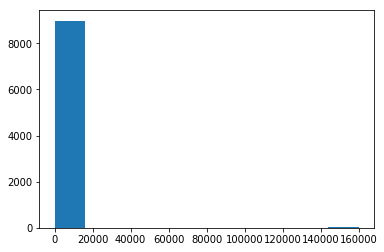

In [75]:
plt.hist(train_raw.P_avg)

In [77]:
#引入工程知识，去除P_avg大于20000的记录
train_cleansed = train_raw.drop(train_raw[train_raw.P_avg>20000].index)

print(str(train_raw.shape[0]-train_cleansed.shape[0])+" samples have been removed due to extremely exceptional average power value")

In [98]:
def train_with_lightgbm(training_set):
    test_predicts = []
    val_preds = np.zeros(training_set.shape[0])
    for n_fold, (tra_idx, val_idx) in enumerate(kf.split(training_set)):
        tra = training_set.iloc[tra_idx]
        val = training_set.iloc[val_idx]
    
        train_set = lightgbm.Dataset(
            tra[predictor],
            tra['y']
        )
    
        validation_set = lightgbm.Dataset(
            val[predictor],
            val['y']
        )
    
        model = lightgbm.train(params, train_set, num_boost_round=5000,
                              valid_sets= [validation_set],
                              valid_names=['valid'],
                              early_stopping_rounds=100,
                               feval=my_val,
                              verbose_eval=100)

        val_preds[val_idx] = model.predict(val[predictor])
        test_predicts.append(model.predict(test_raw[predictor]))
        
    print(1/(1+np.sqrt(mean_squared_error(training_set['y'],val_preds))))
    
    return test_predicts
   
    

In [99]:
train_with_lightgbm(train_cleansed)

Training until validation scores don't improve for 100 rounds.
[100]	valid's l2: 0.0541969	valid's score: 0.81116
[200]	valid's l2: 0.051429	valid's score: 0.815142
[300]	valid's l2: 0.0508898	valid's score: 0.815935
[400]	valid's l2: 0.0506109	valid's score: 0.816347
[500]	valid's l2: 0.0504891	valid's score: 0.816528
[600]	valid's l2: 0.0502926	valid's score: 0.81682
[700]	valid's l2: 0.0502125	valid's score: 0.816939
[800]	valid's l2: 0.0502594	valid's score: 0.816869
Early stopping, best iteration is:
[713]	valid's l2: 0.0501896	valid's score: 0.816973
Training until validation scores don't improve for 100 rounds.
[100]	valid's l2: 0.0324366	valid's score: 0.847385
[200]	valid's l2: 0.0296534	valid's score: 0.853095
[300]	valid's l2: 0.0291536	valid's score: 0.854157
[400]	valid's l2: 0.0286634	valid's score: 0.855211
[500]	valid's l2: 0.0283041	valid's score: 0.85599
[600]	valid's l2: 0.028205	valid's score: 0.856206
[700]	valid's l2: 0.0281294	valid's score: 0.856371
[800]	valid'

[array([0.38411308, 1.35035988, 2.14985669, ..., 9.88598302, 9.98462019,
        9.09088041]),
 array([ 0.38075007,  1.30331551,  2.17994922, ..., 10.01314201,
         9.96607772,  9.1624529 ]),
 array([0.39201691, 1.28727815, 2.18120637, ..., 9.88918082, 9.93395191,
        9.11688837]),
 array([0.38886958, 1.3220964 , 2.13822816, ..., 9.98920505, 9.96147456,
        9.12534949]),
 array([0.38685236, 1.19586396, 2.13771542, ..., 9.96853915, 9.90689465,
        9.0813672 ])]

In [100]:
test['ans'] = np.mean(test_predicts, axis=0)
test[['ID','ans']].to_csv('../result/baseline073101.csv',header=False, index=False)

In [ ]:
#Trail 2, 导入手工通过线性回归校正异常电流电压值

In [102]:
train_raw = pd.read_csv('../data/public.train.csv')
test_raw = pd.read_csv('../data/test_corrected_by_lm.csv')

train_raw_len = train_raw.shape[0]

#为了统一处理表头编码问题，合并
train_test_raw = pd.concat([train_raw, test_raw],sort=False)

train_test_raw.rename(index=str, columns=rep_cols, inplace=True)

train_test_raw.head()

,ID,board_t,env_t,light_strength,efficiency,efficiency_A,efficiency_B,efficiency_C,V_A,V_B,...,I_A,I_B,I_C,P_A,P_B,P_C,P_avg,wind_speed,wind_direction,y
0,10,-19.14,-17.4,34,80.55,106.32,16.98,118.36,729.0,709.0,...,1.34,0.22,1.50,976.86,155.98,1087.50,740.11,0.6,272,1.437752
1,11,-18.73,-17.3,30,99.90,139.00,21.20,139.51,728.0,717.0,...,1.55,0.24,1.56,1128.40,172.08,1132.56,811.01,0.8,275,1.692575
2,12,-17.54,-17.0,41,82.48,114.86,14.91,117.66,731.0,722.0,...,1.75,0.23,1.82,1279.25,166.06,1310.40,918.57,1.1,283,1.975787
3,14,-15.43,-16.6,53,73.98,101.72,15.55,104.67,730.0,727.0,...,2.02,0.31,2.09,1474.60,225.37,1517.34,1072.44,0.9,280,2.370656
4,15,-14.60,-16.3,65,64.62,86.86,13.09,93.92,727.0,729.0,...,2.13,0.32,2.30,1548.51,233.28,1674.40,1152.06,1.1,280,2.532091


In [103]:
#覆盖**_raw，数据内容未变，表头已转为英文
train_raw = train_test_raw.iloc[0:train_raw_len]
test_raw = train_test_raw.iloc[train_raw_len:]

In [104]:
#引入工程知识，去除P_avg大于20000的记录
train_cleansed = train_raw.drop(train_raw[train_raw.P_avg>20000].index)

print(str(train_raw.shape[0]-train_cleansed.shape[0])+" samples have been removed due to extremely exceptional average power value")

23 samples have been removed due to extremely exceptional average power value


In [105]:
train_with_lightgbm(train_cleansed)

Training until validation scores don't improve for 100 rounds.
[100]	valid's l2: 0.0541969	valid's score: 0.81116
[200]	valid's l2: 0.051429	valid's score: 0.815142
[300]	valid's l2: 0.0508898	valid's score: 0.815935
[400]	valid's l2: 0.0506109	valid's score: 0.816347
[500]	valid's l2: 0.0504891	valid's score: 0.816528
[600]	valid's l2: 0.0502926	valid's score: 0.81682
[700]	valid's l2: 0.0502125	valid's score: 0.816939
[800]	valid's l2: 0.0502594	valid's score: 0.816869
Early stopping, best iteration is:
[713]	valid's l2: 0.0501896	valid's score: 0.816973
Training until validation scores don't improve for 100 rounds.
[100]	valid's l2: 0.0324366	valid's score: 0.847385
[200]	valid's l2: 0.0296534	valid's score: 0.853095
[300]	valid's l2: 0.0291536	valid's score: 0.854157
[400]	valid's l2: 0.0286634	valid's score: 0.855211
[500]	valid's l2: 0.0283041	valid's score: 0.85599
[600]	valid's l2: 0.028205	valid's score: 0.856206
[700]	valid's l2: 0.0281294	valid's score: 0.856371
[800]	valid'

[array([0.38411308, 1.35035988, 2.14985669, ..., 9.88598302, 9.98462019,
        9.09088041]),
 array([ 0.38075007,  1.30331551,  2.17994922, ..., 10.01314201,
         9.96607772,  9.1624529 ]),
 array([0.39201691, 1.28727815, 2.18120637, ..., 9.88918082, 9.93395191,
        9.11688837]),
 array([0.38886958, 1.3220964 , 2.13822816, ..., 9.98920505, 9.96147456,
        9.12534949]),
 array([0.38685236, 1.19586396, 2.13771542, ..., 9.96853915, 9.90689465,
        9.0813672 ])]

In [106]:
test['ans'] = np.mean(test_predicts, axis=0)
test[['ID','ans']].to_csv('../result/baseline073102.csv',header=False, index=False)